In [40]:
import torch
import torch.nn as nn

import torchvision
from torchvision import models
import torchvision.transforms as v1
from torchvision.transforms import v2

from PIL import Image

### Model classes creation

In [2]:
def conv3x3(in_chanels, out_chanels, stride=1):
    return nn.Conv2d(
        in_chanels,
        out_chanels,
        kernel_size=(3, 3),
        stride=stride,
        padding=1,
        bias=False
    )
def conv1x1(in_chanels, out_chanels, stride=1):
    return nn.Conv2d(
        in_chanels,
        out_chanels,
        kernel_size=(1, 1),
        stride=stride,
        bias=False
    )

In [3]:
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_chanels, out_chanels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv3x3(in_chanels, out_chanels, stride)
        self.bn1 = nn.BatchNorm2d(out_chanels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(in_chanels, out_chanels, stride)
        self.bn2 = nn.BatchNorm2d(out_chanels)
        self.downsample = downsample
    
    def forward(self, x):
        identify = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identify = self.downsample(x)
        
        out += identify
        out = self.relu(out)
        
        return out  

In [4]:
class Bottleneck(nn.Module):
    expansion = 4
    
    def __init__(self, in_chanels, out_chanels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv1x1(in_chanels, out_chanels)
        self.bn1 = nn.BatchNorm2d(out_chanels)
        self.conv2 = conv3x3(out_chanels, out_chanels, stride)
        self.bn2 = nn.BatchNorm2d(out_chanels)
        self.conv3 = conv1x1(out_chanels, out_chanels*self.expansion)
        self.bn3 = nn.BatchNorm2d(out_chanels*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
    
    def forward(self, x):
        identify = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample is not None:
            identify = self.downsample(x)
        
        out += identify
        out = self.relu(out)
        
        return out    

In [5]:
class ResNet(nn.Module):
    cfgs = {
        'resnet18': (BasicBlock, [2, 2, 2, 2]),
        'resnet34': (BasicBlock, [3, 4, 6, 3]),
        'resnet50': (Bottleneck, [3, 4, 6, 3]),
        'resnet101': (Bottleneck, [3, 4, 23, 3]),
        'resnet152': (Bottleneck, [3, 8, 36, 3])
    }
    
    def __init__(self, name, num_classes=1000):
        super().__init__()
        block, layers = self.cfgs[name]
        
        self.inplanes = 64
        
        self.conv1 = nn.Conv2d(3, self.inplanes, (7, 7), stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((3, 3), stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d((7, 7))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        out = self.fc(x)
        
        return out
    
    def make_layer(self, block, out_chanels, blocks, stride=1):
        layers = []
        
        downsample = None
        
        if stride != 1 or self.inplanes != out_chanels * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, out_chanels * block.expansion, stride),
                nn.BatchNorm2d(out_chanels * block.expansion)
            )
        
        layers.append(
            block(self.inplanes, out_chanels, stride, downsample)
        )
        self.inplanes = out_chanels * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(self.inplanes, out_chanels)
            )
        return nn.Sequential(*layers)

In [41]:
model_res = ResNet('resnet152')

#### Model test

In [42]:
inp = torch.rand([1, 3, 224, 224], dtype=torch.float32)
pred = model_res(inp)
pred.shape

torch.Size([1, 1000])

### Upload model with pre-trained  weightts

In [44]:
resnet = models.resnet50(weights='DEFAULT')

#### Model classes

In [46]:
weights_resnet50 = models.ResNet50_Weights.DEFAULT

In [47]:
class_names = weights_resnet50.meta['categories']
print(type(class_names))
print(len(class_names))
print(class_names[:5])

<class 'list'>
1000
['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead']


### Model prediction

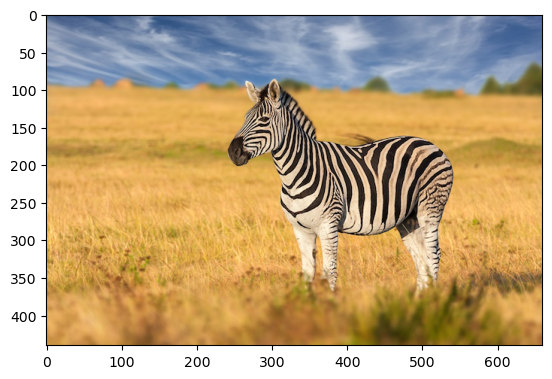

In [48]:
img = Image.open('/Users/alexeyfilichkin/Desktop/PyTorch/44235ac5.jpg')
plt.imshow(img)

In [49]:
#### Image transform

In [50]:
transform = v2.Compose([
    v2.RGB(),
    v2.ToImage(),
    v2.Resize(224),
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [51]:
img_in = transform(img).unsqueeze(dim=0)

In [52]:
resnet.eval()
pred = resnet(img_in).squeeze()
sorted_, indices = pred.softmax(dim=0).sort(descending=True)
for i, (s, ind) in enumerate(zip(sorted_, indices)):
    print(f'    {class_names[ind]} => {s:.5f}')
    if i//5:
        break

    zebra => 0.44753
    ostrich => 0.00220
    hartebeest => 0.00206
    hyena => 0.00166
    bustard => 0.00130
    chambered nautilus => 0.00109
